# Import necessary libraries

In [1]:
import numpy as np 
from numpy import mean
from numpy import percentile
from numpy import sort

import pandas as pd 

import seaborn as sns

import copy as cp

import random

import sklearn
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
 
from xgboost import plot_importance
import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from matplotlib import pyplot

import shap

In [2]:
model_data = pd.read_csv('C:/Users/User 1/Downloads/train.csv',index_col=0)
test_data = pd.read_csv('C:/Users/User 1/Downloads/test.csv',index_col=0)

In [3]:
model_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Delete missing and categorize correct variables
Only loans with 40, 30 and 15 year terms are included.  The rest are investor type loans

In [4]:
model_data=model_data.dropna()
test_data=test_data.dropna()

In [5]:
##testing which works for 30 year program best
model_data=model_data.loc[(model_data['Loan_Amount_Term'] == 360.)  | (model_data['Loan_Amount_Term'] == 180.) | (model_data['Loan_Amount_Term'] == 480.)]
test_data=test_data.loc[(test_data['Loan_Amount_Term'] == 360.)  | (test_data['Loan_Amount_Term'] == 180.) | (test_data['Loan_Amount_Term'] == 480.)]

##categorical change as term is not numerical but designates it as fitting into a category
model_data['Loan_Amount_Term']=model_data.Loan_Amount_Term.astype('category')
test_data['Loan_Amount_Term']=test_data.Loan_Amount_Term.astype('category')

model_data['Credit_History']=model_data['Credit_History'].astype(str)
test_data['Credit_History']=test_data['Credit_History'].astype(str)

In [6]:
model_data.pop('Self_Employed')
test_data.pop('Self_Employed')

model_data.pop('Dependents')
test_data.pop('Dependents')

model_data.pop('Married')
test_data.pop('Married')

model_data.pop('Gender')
test_data.pop('Gender')

model_data.pop('Property_Area')
test_data.pop('Property_Area')

model_data.pop('Education')
test_data.pop('Education')

Loan_ID
LP001015        Graduate
LP001022        Graduate
LP001031        Graduate
LP001051    Not Graduate
LP001054    Not Graduate
                ...     
LP002969        Graduate
LP002971    Not Graduate
LP002975        Graduate
LP002986        Graduate
LP002989        Graduate
Name: Education, Length: 274, dtype: object

In [7]:
from sklearn.preprocessing import LabelEncoder
target=model_data.pop('Loan_Status')
le = LabelEncoder()
le.fit(target)
target=pd.DataFrame(le.transform(target))
target.rename(columns = {0:'Loan_Status'}, 
            inplace = True)

In [8]:
def encode_fun(big_d):

    categorical_columns=big_d.select_dtypes(include=['object', 'category']).columns
   
    for column in categorical_columns:
        inserts = pd.get_dummies(big_d[column], prefix=column)

        big_d = pd.merge(
            left=big_d,
            right=inserts,
            left_index=True,
            right_index=True,
        )
        
        big_d = big_d.drop(columns=column)
        
    return big_d,categorical_columns

In [9]:
new_data,cat_cols=encode_fun(cp.deepcopy(model_data))

##standardize data in numerical columns
##not explicitly needed for xgboost as it is tree-based.  in here for best practice
num_cols = new_data.columns[new_data.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
scaler = StandardScaler()
new_data[num_cols] = scaler.fit_transform(new_data[num_cols])

In [10]:
new_data.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term_180.0,Loan_Amount_Term_360.0,Loan_Amount_Term_480.0,Credit_History_0.0,Credit_History_1.0
Loan_ID,,,,,,,,
LP001003,-0.144591,-0.032048,-0.220530,-0.29173,0.341743,-0.163846,-0.413423,0.413423
LP001005,-0.418997,-0.604224,-0.993228,-0.29173,0.341743,-0.163846,-0.413423,0.413423
LP001006,-0.491283,0.290465,-0.320233,-0.29173,0.341743,-0.163846,-0.413423,0.413423
LP001008,0.101041,-0.604224,-0.058513,-0.29173,0.341743,-0.163846,-0.413423,0.413423
LP001011,-0.000020,0.987853,1.511808,-0.29173,0.341743,-0.163846,-0.413423,0.413423


In [11]:
X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size=0.3,random_state=2,shuffle=True)

In [12]:
evalset = [(X_train, y_train), (X_test,y_test)]

In [13]:
model = XGBClassifier(n_estimators=1000)

In [14]:
model.fit(X_train, y_train, eval_metric='auc', eval_set=evalset)

[0]	validation_0-auc:0.77456	validation_1-auc:0.83510
[1]	validation_0-auc:0.86564	validation_1-auc:0.80610
[2]	validation_0-auc:0.89884	validation_1-auc:0.80011
[3]	validation_0-auc:0.91198	validation_1-auc:0.81182
[4]	validation_0-auc:0.93371	validation_1-auc:0.83047
[5]	validation_0-auc:0.95235	validation_1-auc:0.83728
[6]	validation_0-auc:0.95489	validation_1-auc:0.83946
[7]	validation_0-auc:0.95843	validation_1-auc:0.83987
[8]	validation_0-auc:0.96235	validation_1-auc:0.83007
[9]	validation_0-auc:0.96851	validation_1-auc:0.82121
[10]	validation_0-auc:0.97043	validation_1-auc:0.82312
[11]	validation_0-auc:0.97435	validation_1-auc:0.82938
[12]	validation_0-auc:0.97626	validation_1-auc:0.82748
[13]	validation_0-auc:0.97764	validation_1-auc:0.82203
[14]	validation_0-auc:0.97978	validation_1-auc:0.81767
[15]	validation_0-auc:0.98432	validation_1-auc:0.82612
[16]	validation_0-auc:0.98646	validation_1-auc:0.82339
[17]	validation_0-auc:0.98673	validation_1-auc:0.81618
[18]	validation_0-au

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[97]	validation_0-auc:1.00000	validation_1-auc:0.82176
[98]	validation_0-auc:1.00000	validation_1-auc:0.82013
[99]	validation_0-auc:1.00000	validation_1-auc:0.82176
[100]	validation_0-auc:1.00000	validation_1-auc:0.82121
[101]	validation_0-auc:1.00000	validation_1-auc:0.82094
[102]	validation_0-auc:1.00000	validation_1-auc:0.82230
[103]	validation_0-auc:1.00000	validation_1-auc:0.82121
[104]	validation_0-auc:1.00000	validation_1-auc:0.82094
[105]	validation_0-auc:1.00000	validation_1-auc:0.82067
[106]	validation_0-auc:1.00000	validation_1-auc:0.82067
[107]	validation_0-auc:1.00000	validation_1-auc:0.82312
[108]	validation_0-auc:1.00000	validation_1-auc:0.82312
[109]	validation_0-auc:1.00000	validation_1-auc:0.82312
[110]	validation_0-auc:1.00000	validation_1-auc:0.82312
[111]	validation_0-auc:1.00000	validation_1-auc:0.82312
[112]	validation_0-auc:1.00000	validation_1-auc:0.82339
[113]	validation_0-auc:1.00000	validation_1-auc:0.82475
[114]	validation_0-auc:1.00000	validation_1-auc:0.8

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [15]:
yhat = model.predict(X_test)
yhat_train = model.predict(X_train)
score = accuracy_score(y_test, yhat)
train_score=accuracy_score(y_train, yhat_train)
print('Train Accuracy: %.3f' % train_score)
print('Accuracy: %.3f' % score)

Train Accuracy: 0.997
Accuracy: 0.855


In [16]:
##history of model metrics at each estimator
results = model.evals_result()

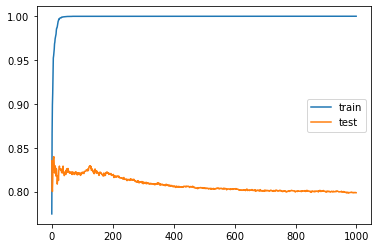

In [17]:
# plot learning curves
pyplot.plot(results['validation_0']['auc'], label='train')
pyplot.plot(results['validation_1']['auc'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Training model witht the optimal estimators to gain highest metric

In [18]:
max_estimators_model=np.argmax(results['validation_1']['auc'])+1
est_model = XGBClassifier(n_estimators=max_estimators_model)
est_model.fit(X_train, y_train, eval_metric='auc', eval_set=evalset)

[0]	validation_0-auc:0.77456	validation_1-auc:0.83510
[1]	validation_0-auc:0.86564	validation_1-auc:0.80610
[2]	validation_0-auc:0.89884	validation_1-auc:0.80011
[3]	validation_0-auc:0.91198	validation_1-auc:0.81182
[4]	validation_0-auc:0.93371	validation_1-auc:0.83047
[5]	validation_0-auc:0.95235	validation_1-auc:0.83728
[6]	validation_0-auc:0.95489	validation_1-auc:0.83946
[7]	validation_0-auc:0.95843	validation_1-auc:0.83987


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=8, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [19]:
yhat = est_model.predict(X_test)
yhat_train = est_model.predict(X_train)
score = accuracy_score(y_test, yhat)
train_score=accuracy_score(y_train, yhat_train)
print('Train Accuracy: %.3f' % train_score)
print('Accuracy: %.3f' % score)

Train Accuracy: 0.872
Accuracy: 0.833


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

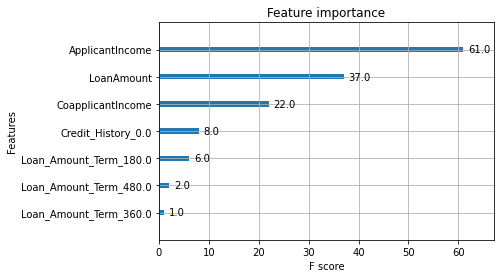

In [21]:
plot_importance(est_model)

Accuracy  test dataset:  t 0.8333333333333334
ROC-AUC score  test dataset:  t 0.7344771241830065
precision score  test dataset:  t 0.8495575221238938
Recall score  test dataset:  t 0.9411764705882353
f1 score  test dataset :  t 0.8930232558139535


Text(0.5, 257.44, 'Predicted label')

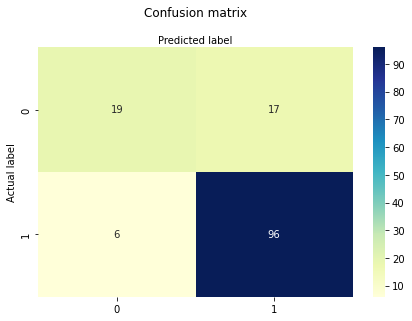

In [22]:
y_pred_prob_test = est_model.predict_proba(X_test)[:, 1]
#predict labels on test dataset
y_pred_test = yhat
# Accuracy 
print("Accuracy  test dataset:  t", accuracy_score(y_test,y_pred_test))
# ROC- AUC score
print("ROC-AUC score  test dataset:  t", metrics.roc_auc_score(y_test,y_pred_test))
#Precision score
print("precision score  test dataset:  t", metrics.precision_score(y_test,y_pred_test))#,average='micro'))
#Recall Score
print("Recall score  test dataset:  t", metrics.recall_score(y_test,y_pred_test))
#f1 score
print("f1 score  test dataset :  t", f1_score(y_test,y_pred_test))#,average='binary'))

cm = metrics.confusion_matrix(y_test,yhat)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Finding the optimal threshold for the model with defined estimators

In [23]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = est_model.predict_proba(X_test)

probs = yhat[:, 1]
# define thresholds
thresholds = np.linspace(0,1,1000)
# evaluate each threshold
f1scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
aocscores = [roc_auc_score(y_test, to_labels(probs, t)) for t in thresholds]
accuracy  = [accuracy_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
f1_index = np.argmax(f1scores)
aoc_index= np.argmax(aocscores)
accuracy_index = np.argmax(accuracy)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[f1_index], f1scores[f1_index]))
print('Threshold=%.3f, AOC=%.5f' % (thresholds[aoc_index], aocscores[aoc_index]))
print('Threshold=%.3f, Accuracy=%.5f' % (thresholds[accuracy_index], accuracy[accuracy_index]))

Threshold=0.267, F-Score=0.90991
Threshold=0.733, AOC=0.78023
Threshold=0.267, Accuracy=0.85507


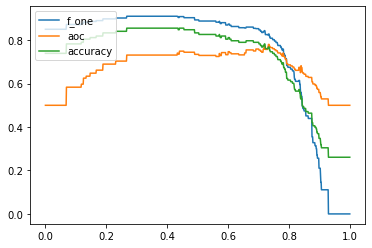

In [24]:
plt.plot(thresholds,f1scores,label="f_one")
plt.plot(thresholds,aocscores,label="aoc")
plt.plot(thresholds,accuracy,label="accuracy")
plt.legend(loc="upper left")

plt.show()

Accuracy  test dataset:  t 0.855072463768116
ROC-AUC score  test dataset:  t 0.7312091503267975
f1 score  test dataset :  t 0.9099099099099098


Text(0.5, 257.44, 'Predicted label')

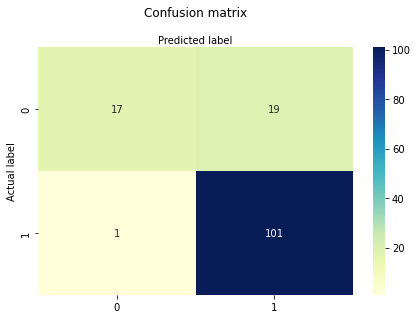

In [25]:
opt_threshold=.267

y_pred_prob_test = (est_model.predict_proba(X_test)[:, 1] >=opt_threshold).astype('int') 

cnf_matrix = metrics.confusion_matrix(y_test,y_pred_prob_test)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
print("Accuracy  test dataset:  t", accuracy_score(y_test,y_pred_prob_test))
print("ROC-AUC score  test dataset:  t", metrics.roc_auc_score(y_test,y_pred_prob_test))
print("f1 score  test dataset :  t", f1_score(y_test,y_pred_prob_test))#,average='binary'))
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Now for hyperparameter tuning

In [26]:
xgb_model = XGBClassifier(use_label_encoder=False)
#listing parameters for searching grid 
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

#searching best parameters
search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            n_iter=200, random_state=42,cv=5, verbose=1, 
                            n_jobs=1, return_train_score=True)

#training the model to find the optimal parameters
search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           num_parallel_tree=None,
                                           predictor=None, random_state

In [27]:
#set model with optimal parameters
def tuned_hyper(search_results):
     
    first_spot=int(search_results['rank_test_score'][0])
    winning_combo=search_results['params'][first_spot]
    col_tree=winning_combo['colsample_bytree']
    gams=winning_combo['gamma']
    lr=winning_combo['learning_rate']
    m_dep=winning_combo['max_depth']
    min_ch=winning_combo['min_child_weight']

    #setting the model up with best parameters
    best_model= XGBClassifier(colsample_bytree=col_tree,
                              gamma=gams,
                              learning_rate=lr,
                              max_depth=m_dep,
                              use_label_encoder=False,
                              min_child_weight=min_ch
                             )
    return best_model

Accuracy  test dataset:  t 0.8478260869565217
ROC-AUC score  test dataset:  t 0.7622549019607842
precision score  test dataset:  t 0.8648648648648649
Recall score  test dataset:  t 0.9411764705882353
f1 score  test dataset :  t 0.9014084507042254


Text(0.5, 257.44, 'Predicted label')

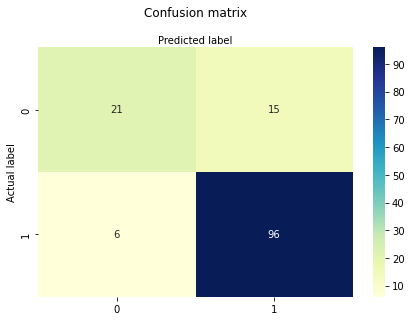

In [28]:
#function run
a=tuned_hyper(search.cv_results_)

#fitting best model
a.fit(X_train, y_train)

preds=a.predict(X_test)

y_pred_prob_test = a.predict_proba(X_test)[:, 1]
#predict labels on test dataset
y_pred_test = preds
# Accuracy 
print("Accuracy  test dataset:  t", accuracy_score(y_test,y_pred_test))
# ROC- AUC score
print("ROC-AUC score  test dataset:  t", metrics.roc_auc_score(y_test,y_pred_test))
#Precision score
print("precision score  test dataset:  t", metrics.precision_score(y_test,y_pred_test))#,average='micro'))
#Recall Score
print("Recall score  test dataset:  t", metrics.recall_score(y_test,y_pred_test))
#f1 score
print("f1 score  test dataset :  t", f1_score(y_test,y_pred_test))#,average='binary'))

cm = metrics.confusion_matrix(y_test,preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Finding optimal probability threshold for tuned model

In [29]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = a.predict_proba(X_test)

probs = yhat[:, 1]
# define thresholds
thresholds = np.linspace(0,1,1000)
# evaluate each threshold
f1scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
aocscores = [roc_auc_score(y_test, to_labels(probs, t)) for t in thresholds]
accuracy  = [accuracy_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
f1_index = np.argmax(f1scores)
aoc_index= np.argmax(aocscores)
accuracy_index = np.argmax(accuracy)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[f1_index], f1scores[f1_index]))
print('Threshold=%.3f, AOC=%.5f' % (thresholds[aoc_index], aocscores[aoc_index]))
print('Threshold=%.3f, Accuracy=%.5f' % (thresholds[accuracy_index], accuracy[accuracy_index]))

Threshold=0.167, F-Score=0.90667
Threshold=0.732, AOC=0.79739
Threshold=0.465, Accuracy=0.85507


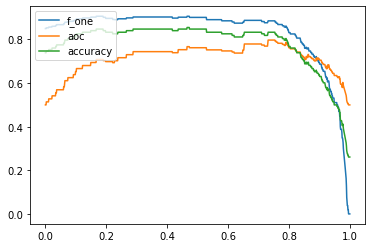

In [30]:
plt.plot(thresholds,f1scores,label="f_one")
plt.plot(thresholds,aocscores,label="aoc")
plt.plot(thresholds,accuracy,label="accuracy")
plt.legend(loc="upper left")

plt.show()

Accuracy  test dataset:  t 0.8478260869565217
ROC-AUC score  test dataset:  t 0.7532679738562091
precision score  test dataset:  t 0.8584070796460177
Recall score  test dataset:  t 0.9509803921568627
f1 score  test dataset :  t 0.9023255813953488


Text(0.5, 257.44, 'Predicted label')

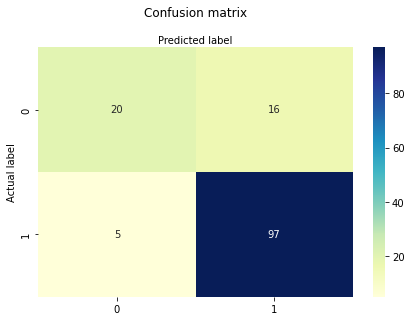

In [31]:
y_pred_prob_test = (model.predict_proba(X_test)[:, 1] >=.465).astype('int') 

cnf_matrix = metrics.confusion_matrix(y_test,y_pred_prob_test)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()

# Accuracy 
print("Accuracy  test dataset:  t", accuracy_score(y_test,y_pred_prob_test))
# ROC- AUC score
print("ROC-AUC score  test dataset:  t", metrics.roc_auc_score(y_test,y_pred_prob_test))
#Precision score
print("precision score  test dataset:  t", metrics.precision_score(y_test,y_pred_prob_test))#,average='micro'))
#Recall Score
print("Recall score  test dataset:  t", metrics.recall_score(y_test,y_pred_prob_test))
#f1 score
print("f1 score  test dataset :  t", f1_score(y_test,y_pred_prob_test))#,average='binary'))

plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [32]:
# save
est_model.save_model("my_xgboost.json")

# load
new_model =XGBClassifier()
new_model.load_model("my_xgboost.json")

# check optimal number of trees of loaded model
new_model.best_ntree_limit

n_estimators is not saved in Scikit-Learn meta.


8

In [33]:
new_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)